<a href="https://colab.research.google.com/github/Darshitavijay/Algal-bloom-prediction/blob/main/Algal_bloom_prediction_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DATA LOADING 

In [ ]:
#importing the necessary libraries 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
algal_data=pd.read_csv("/content/drive/MyDrive/algal bloom prediction /combined.csv")
algal_data.head()

,Unnamed: 0,season,size,speed,mxPH,mnO2,Cl,NO3,NH4,oPO4,PO4,Chla
0,1,winter,small,medium,8.00,9.8,60.800,6.238,578.00000,105.000,170.00000,50.0
1,2,spring,small,medium,8.35,8.0,57.750,1.288,370.00000,428.750,558.75000,1.3
2,3,autumn,small,medium,8.10,11.4,40.020,5.330,346.66699,125.667,187.05701,15.6
3,4,spring,small,medium,8.07,4.8,77.364,2.302,98.18200,61.182,138.70000,1.4
4,5,autumn,small,medium,8.06,9.0,55.350,10.416,233.70000,58.222,97.58000,10.5


 DATA CLEANING

In [ ]:
algal_data.isnull().sum()

Unnamed: 0     0
season         1
size           1
speed          1
mxPH           3
mnO2           3
Cl            17
NO3            3
NH4            3
oPO4           3
PO4            8
Chla          24
dtype: int64

In [ ]:
#To remove null values for the program to properly 
algal_data.dropna(inplace=True)
algal_data.isnull().sum()

Unnamed: 0    0
season        0
size          0
speed         0
mxPH          0
mnO2          0
Cl            0
NO3           0
NH4           0
oPO4          0
PO4           0
Chla          0
dtype: int64

In [ ]:
#to remove the index
algal_data = algal_data.iloc[:, 1:]
algal_data.head(152)

,season,size,speed,mxPH,mnO2,Cl,NO3,NH4,oPO4,PO4,Chla
0,winter,small,medium,8.00,9.80,60.800,6.238,578.00000,105.00000,170.00000,50.000
1,spring,small,medium,8.35,8.00,57.750,1.288,370.00000,428.75000,558.75000,1.300
2,autumn,small,medium,8.10,11.40,40.020,5.330,346.66699,125.66700,187.05701,15.600
3,spring,small,medium,8.07,4.80,77.364,2.302,98.18200,61.18200,138.70000,1.400
4,autumn,small,medium,8.06,9.00,55.350,10.416,233.70000,58.22200,97.58000,10.500
...,...,...,...,...,...,...,...,...,...,...,...
161,spring,large,low,9.50,5.70,44.000,0.102,146.66701,151.33299,252.50000,93.683
162,summer,large,low,8.80,8.80,43.000,0.130,103.33300,180.66701,269.66699,92.667
163,autumn,large,low,8.84,12.90,43.090,0.846,52.20000,8.60000,46.43800,81.540
164,winter,large,high,7.30,9.90,16.000,4.820,101.66700,14.66700,85.00000,2.000


In [ ]:
#since NO3 being greater than 40 seems to be a n outlier we can remove it
algal_data.query("NO3 > 40")
algal_data=algal_data.drop(index=152)

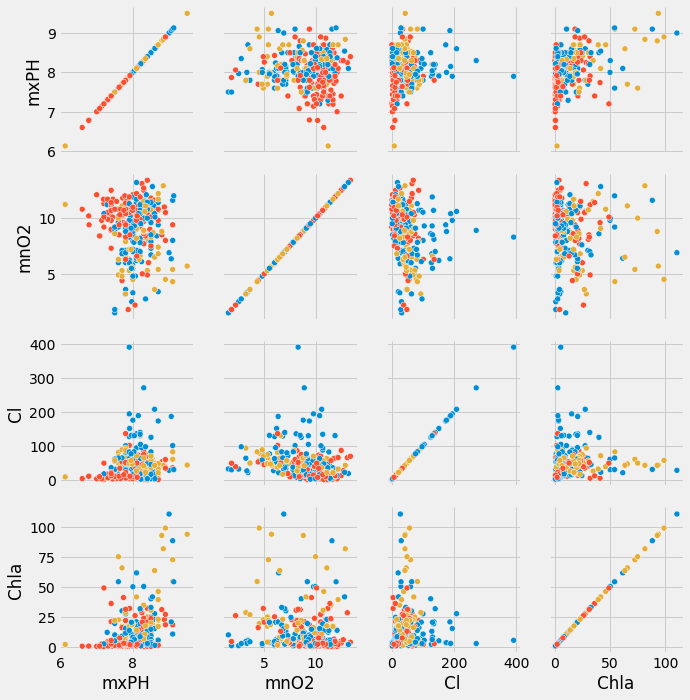

In [ ]:
#to check the traditional measure
algal_set1=["mxPH","mnO2","Cl","Chla","speed"]
g =sns.PairGrid(algal_data[algal_set1], hue="speed")
g.map(sns.scatterplot)

GETTING DUMMIES/ ONE HOT ENCODING 

In [ ]:
 pd.get_dummies(algal_data.season)

,autumn,spring,summer,winter
0,0,0,0,1
1,0,1,0,0
2,1,0,0,0
3,0,1,0,0
4,1,0,0,0
...,...,...,...,...
333,0,0,1,0
335,0,0,1,0
337,0,0,0,1
338,0,0,1,0


In [ ]:
seasons= pd.get_dummies(algal_data.season)
seasons

,autumn,spring,summer,winter
0,0,0,0,1
1,0,1,0,0
2,1,0,0,0
3,0,1,0,0
4,1,0,0,0
...,...,...,...,...
333,0,0,1,0
335,0,0,1,0
337,0,0,0,1
338,0,0,1,0


In [ ]:
merged=pd.concat([algal_data,seasons],axis='columns')
merged

,season,size,speed,mxPH,mnO2,Cl,NO3,NH4,oPO4,PO4,Chla,autumn,spring,summer,winter
0,winter,small,medium,8.00,9.8,60.8000,6.238,578.00000,105.000,170.00000,50.000,0,0,0,1
1,spring,small,medium,8.35,8.0,57.7500,1.288,370.00000,428.750,558.75000,1.300,0,1,0,0
2,autumn,small,medium,8.10,11.4,40.0200,5.330,346.66699,125.667,187.05701,15.600,1,0,0,0
3,spring,small,medium,8.07,4.8,77.3640,2.302,98.18200,61.182,138.70000,1.400,0,1,0,0
4,autumn,small,medium,8.06,9.0,55.3500,10.416,233.70000,58.222,97.58000,10.500,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,summer,large,medium,8.40,10.0,3.5100,0.866,29.65000,5.800,15.00000,2.860,0,0,1,0
335,summer,medium,high,8.12,10.2,7.6130,0.699,33.56000,28.034,49.65800,2.200,0,0,1,0
337,winter,large,low,8.70,11.7,21.4656,3.765,91.45000,38.000,83.00000,17.000,0,0,0,1
338,summer,large,low,8.10,8.2,26.5400,2.805,42.75000,48.500,88.12500,13.980,0,0,1,0


In [ ]:
merged.drop(['season'], axis=1)

,size,speed,mxPH,mnO2,Cl,NO3,NH4,oPO4,PO4,Chla,autumn,spring,summer,winter
0,small,medium,8.00,9.8,60.8000,6.238,578.00000,105.000,170.00000,50.000,0,0,0,1
1,small,medium,8.35,8.0,57.7500,1.288,370.00000,428.750,558.75000,1.300,0,1,0,0
2,small,medium,8.10,11.4,40.0200,5.330,346.66699,125.667,187.05701,15.600,1,0,0,0
3,small,medium,8.07,4.8,77.3640,2.302,98.18200,61.182,138.70000,1.400,0,1,0,0
4,small,medium,8.06,9.0,55.3500,10.416,233.70000,58.222,97.58000,10.500,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,large,medium,8.40,10.0,3.5100,0.866,29.65000,5.800,15.00000,2.860,0,0,1,0
335,medium,high,8.12,10.2,7.6130,0.699,33.56000,28.034,49.65800,2.200,0,0,1,0
337,large,low,8.70,11.7,21.4656,3.765,91.45000,38.000,83.00000,17.000,0,0,0,1
338,large,low,8.10,8.2,26.5400,2.805,42.75000,48.500,88.12500,13.980,0,0,1,0


In [ ]:
speed= pd.get_dummies(algal_data.speed)
speed

,high,low,medium
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
333,0,0,1
335,1,0,0
337,0,1,0
338,0,1,0


In [ ]:
merged=pd.concat([merged,speed],axis='columns')
merged

,season,size,speed,mxPH,mnO2,Cl,NO3,NH4,oPO4,PO4,Chla,autumn,spring,summer,winter,high,low,medium
0,winter,small,medium,8.00,9.8,60.8000,6.238,578.00000,105.000,170.00000,50.000,0,0,0,1,0,0,1
1,spring,small,medium,8.35,8.0,57.7500,1.288,370.00000,428.750,558.75000,1.300,0,1,0,0,0,0,1
2,autumn,small,medium,8.10,11.4,40.0200,5.330,346.66699,125.667,187.05701,15.600,1,0,0,0,0,0,1
3,spring,small,medium,8.07,4.8,77.3640,2.302,98.18200,61.182,138.70000,1.400,0,1,0,0,0,0,1
4,autumn,small,medium,8.06,9.0,55.3500,10.416,233.70000,58.222,97.58000,10.500,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,summer,large,medium,8.40,10.0,3.5100,0.866,29.65000,5.800,15.00000,2.860,0,0,1,0,0,0,1
335,summer,medium,high,8.12,10.2,7.6130,0.699,33.56000,28.034,49.65800,2.200,0,0,1,0,1,0,0
337,winter,large,low,8.70,11.7,21.4656,3.765,91.45000,38.000,83.00000,17.000,0,0,0,1,0,1,0
338,summer,large,low,8.10,8.2,26.5400,2.805,42.75000,48.500,88.12500,13.980,0,0,1,0,0,1,0


In [ ]:
merged.drop(['season', 'size','speed'], axis=1,inplace=True)

In [ ]:
merged

,mxPH,mnO2,Cl,NO3,NH4,oPO4,PO4,Chla,autumn,spring,summer,winter,high,low,medium
0,8.00,9.8,60.8000,6.238,578.00000,105.000,170.00000,50.000,0,0,0,1,0,0,1
1,8.35,8.0,57.7500,1.288,370.00000,428.750,558.75000,1.300,0,1,0,0,0,0,1
2,8.10,11.4,40.0200,5.330,346.66699,125.667,187.05701,15.600,1,0,0,0,0,0,1
3,8.07,4.8,77.3640,2.302,98.18200,61.182,138.70000,1.400,0,1,0,0,0,0,1
4,8.06,9.0,55.3500,10.416,233.70000,58.222,97.58000,10.500,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,8.40,10.0,3.5100,0.866,29.65000,5.800,15.00000,2.860,0,0,1,0,0,0,1
335,8.12,10.2,7.6130,0.699,33.56000,28.034,49.65800,2.200,0,0,1,0,1,0,0
337,8.70,11.7,21.4656,3.765,91.45000,38.000,83.00000,17.000,0,0,0,1,0,1,0
338,8.10,8.2,26.5400,2.805,42.75000,48.500,88.12500,13.980,0,0,1,0,0,1,0


In [ ]:
merged.corr()

,mxPH,mnO2,Cl,NO3,NH4,oPO4,PO4,Chla,autumn,spring,summer,winter,high,low,medium
mxPH,1.000000,-0.050257,0.130379,-0.044352,-0.075230,0.072662,0.068783,0.385617,0.041167,0.016944,-0.134233,0.078929,-0.266525,0.190102,0.118368
mnO2,-0.050257,1.000000,-0.268807,0.087229,-0.268165,-0.296855,-0.364762,-0.112742,0.266340,-0.282091,0.086551,-0.064644,0.304736,-0.191995,-0.154976
Cl,0.130379,-0.268807,1.000000,0.358572,0.107576,0.283088,0.379104,0.123542,-0.046507,0.072880,-0.016680,-0.010748,-0.358378,0.072615,0.300864
NO3,-0.044352,0.087229,0.358572,1.000000,0.054650,0.193059,0.284038,0.094986,0.117942,-0.146272,0.007580,0.023862,-0.159998,0.037598,0.130310
NH4,-0.075230,-0.268165,0.107576,0.054650,1.000000,0.624881,0.633481,-0.060167,-0.007850,0.019755,-0.005496,-0.006553,-0.215890,-0.038842,0.245191
oPO4,0.072662,-0.296855,0.283088,0.193059,0.624881,1.000000,0.935687,0.051345,-0.077849,0.069293,0.042561,-0.036657,-0.240797,0.051432,0.200107
PO4,0.068783,-0.364762,0.379104,0.284038,0.633481,0.935687,1.000000,0.174237,-0.063906,0.080311,0.007575,-0.025812,-0.318065,0.107612,0.233596
Chla,0.385617,-0.112742,0.123542,0.094986,-0.060167,0.051345,0.174237,1.000000,0.075280,-0.011896,-0.121228,0.061415,-0.244530,0.363144,-0.037538
autumn,0.041167,0.266340,-0.046507,0.117942,-0.007850,-0.077849,-0.063906,0.075280,1.000000,-0.320110,-0.328454,-0.320110,-0.045261,0.069705,-0.008875
spring,0.016944,-0.282091,0.072880,-0.146272,0.019755,0.069293,0.080311,-0.011896,-0.320110,1.000000,-0.346523,-0.337719,-0.004685,-0.032284,0.029666


In [ ]:
correlation = merged. corr ()  
correlation. style. background_gradient (cmap = 'BrBG')  

,mxPH,mnO2,Cl,NO3,NH4,oPO4,PO4,Chla,autumn,spring,summer,winter,high,low,medium
mxPH,1.000000,-0.050257,0.130379,-0.044352,-0.075230,0.072662,0.068783,0.385617,0.041167,0.016944,-0.134233,0.078929,-0.266525,0.190102,0.118368
mnO2,-0.050257,1.000000,-0.268807,0.087229,-0.268165,-0.296855,-0.364762,-0.112742,0.266340,-0.282091,0.086551,-0.064644,0.304736,-0.191995,-0.154976
Cl,0.130379,-0.268807,1.000000,0.358572,0.107576,0.283088,0.379104,0.123542,-0.046507,0.072880,-0.016680,-0.010748,-0.358378,0.072615,0.300864
NO3,-0.044352,0.087229,0.358572,1.000000,0.054650,0.193059,0.284038,0.094986,0.117942,-0.146272,0.007580,0.023862,-0.159998,0.037598,0.130310
NH4,-0.075230,-0.268165,0.107576,0.054650,1.000000,0.624881,0.633481,-0.060167,-0.007850,0.019755,-0.005496,-0.006553,-0.215890,-0.038842,0.245191
oPO4,0.072662,-0.296855,0.283088,0.193059,0.624881,1.000000,0.935687,0.051345,-0.077849,0.069293,0.042561,-0.036657,-0.240797,0.051432,0.200107
PO4,0.068783,-0.364762,0.379104,0.284038,0.633481,0.935687,1.000000,0.174237,-0.063906,0.080311,0.007575,-0.025812,-0.318065,0.107612,0.233596
Chla,0.385617,-0.112742,0.123542,0.094986,-0.060167,0.051345,0.174237,1.000000,0.075280,-0.011896,-0.121228,0.061415,-0.244530,0.363144,-0.037538
autumn,0.041167,0.266340,-0.046507,0.117942,-0.007850,-0.077849,-0.063906,0.075280,1.000000,-0.320110,-0.328454,-0.320110,-0.045261,0.069705,-0.008875
spring,0.016944,-0.282091,0.072880,-0.146272,0.019755,0.069293,0.080311,-0.011896,-0.320110,1.000000,-0.346523,-0.337719,-0.004685,-0.032284,0.029666


<Axes: >

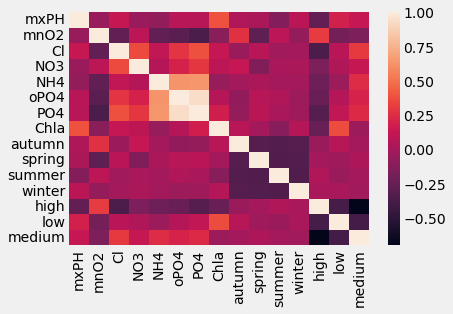

In [ ]:
sns.heatmap(merged.corr())

<Axes: >

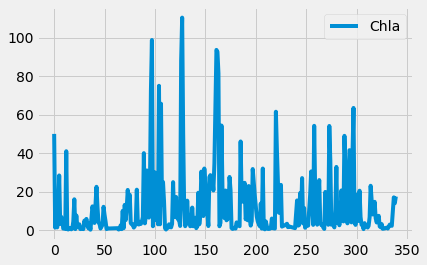

In [ ]:
merged.plot.line(y='Chla', use_index=True)

TRAINING AND MODELLING USING CHLOROPHYLL AS PREDICTOR VALUE 

In [ ]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(merged, test_size=0.2, random_state=50)

In [ ]:
x_train=merged.drop("Chla",axis=1)
y_train=merged["Chla"]
x_test=test_data.drop("Chla",axis=1)
y_test=test_data["Chla"]

In [ ]:
merged.shape

(305, 15)

**EXISTING METHODOLOGY** 

1. LINEAR REGRESSION 

In [ ]:
from sklearn.linear_model import LinearRegression
import sklearn
from sklearn import linear_model

In [ ]:
reg = linear_model.LinearRegression()

In [ ]:
reg.fit(x_train, y_train)

LinearRegression()

In [ ]:
reg.score(x_test,y_test)

0.3768503599337629

In [ ]:
pred=reg.predict(x_test)
pred

array([ 35.2775063 ,   6.97707397,  12.51038327,   6.22541816,
        26.35961811,   6.11111105,   1.76550368,   2.32997534,
        30.9866972 ,   3.80976857,  21.32394577, -11.01879433,
         8.44926678,  28.80806439,  10.74809942,   3.23147836,
         9.54781886,  17.52360204,  18.28448589,  -3.93860783,
         9.99795232,   6.8837812 ,  19.57247964,  10.73364981,
        22.13660444,   1.65474613,  10.5135609 ,   6.24588303,
        10.08523619,  27.94143064,  25.97041878,  12.52137412,
         2.10776383,  17.42098811,  17.16329836,   9.34411795,
        11.87276849,  10.15546777,   7.62554051,   9.74177933,
         9.07035956,  15.2960973 ,  -5.12550674,  13.306915  ,
         8.01311674,   4.33560845,  31.51886171,  19.80548845,
        18.01463004,  16.44164178,  10.39550047,   0.44571883,
         3.74875917,  24.3096104 ,  34.46622962,   8.4356017 ,
        40.13440518,  27.88379469,  15.13981537,   9.10172318,
        -2.98386336])

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(pred, y_test))
print(f"Root mean squared error is {rmse}")

Root mean squared error is 14.319466651682372


In [ ]:
slope=reg.coef_
intercept=reg.intercept_
intercept

-90.03145804216449

In [ ]:
# regression coefficients
print('Coefficients: ', reg.coef_)

# variance score: 1 means perfect prediction
print('Variance score: {}'.format(reg.score(x_test, y_test)))

Coefficients:  [ 1.21415938e+01  8.40326072e-02 -2.69373289e-02 -6.69592685e-02
 -2.27213713e-03 -1.24315664e-01  1.21539469e-01  1.30840187e+00
 -8.33111562e-01 -1.36042612e+00  8.85135819e-01 -3.60727815e+00
  7.16947259e+00 -3.56219444e+00]
Variance score: 0.3768503599337629


In [ ]:
import matplotlib.pyplot as plt

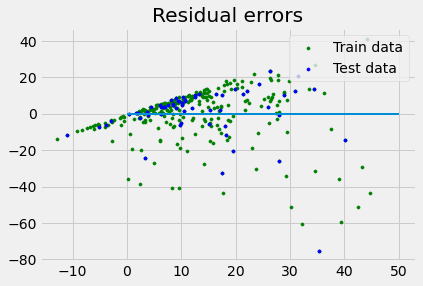

In [ ]:
# setting plot style
plt.style.use('fivethirtyeight')
# plotting residual errors in training data
plt.scatter(reg.predict(x_train), reg.predict(x_train) - y_train,
			color = "green", s = 10, label = 'Train data')
# plotting residual errors in test data
plt.scatter(reg.predict(x_test), reg.predict(x_test) - y_test,
			color = "blue", s = 10, label = 'Test data')
# plotting line for zero residual error
plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2)
# plotting legend
plt.legend(loc = 'upper right')
# plot title
plt.title("Residual errors")
# method call for showing the plot
plt.show()

2. BASIC NEURAL NETWORK 

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
x_train_scaled 

array([[-0.14492787,  0.32511591,  0.37519311, ..., -0.82769733,
        -0.46383126,  1.18388125],
       [ 0.59976768, -0.44433115,  0.30755591, ..., -0.82769733,
        -0.46383126,  1.18388125],
       [ 0.06784229,  1.00906886, -0.08562688, ..., -0.82769733,
        -0.46383126,  1.18388125],
       ...,
       [ 1.34446322,  1.13731004, -0.49709167, ..., -0.82769733,
         2.15595643, -0.84467932],
       [ 0.06784229, -0.35883703, -0.38456112, ..., -0.82769733,
         2.15595643, -0.84467932],
       [ 0.59976768,  0.88082768, -0.47282211, ..., -0.82769733,
         2.15595643, -0.84467932]])

In [ ]:
from tensorflow import keras
from keras import layers

In [ ]:
x_train_scaled[0].shape

(14,)

In [ ]:
model = keras.Sequential()
model.add(layers.Dense(16,activation='relu',input_shape=x_train_scaled[0].shape))
model.add(layers.Dense(1))

In [ ]:
model.compile(optimizer='SGD',loss='mean_squared_error')

In [ ]:
#fitting the model
model.fit(x_train_scaled,y_train,epochs=10)

Epoch 1/10
10/10 [==============================] - 0s 2ms/step - loss: 370.2474
Epoch 2/10
10/10 [==============================] - 0s 2ms/step - loss: 231.8721
Epoch 3/10
10/10 [==============================] - 0s 2ms/step - loss: 239.9347
Epoch 4/10
10/10 [==============================] - 0s 2ms/step - loss: 219.2988
Epoch 5/10
10/10 [==============================] - 0s 2ms/step - loss: 203.6577
Epoch 6/10
10/10 [==============================] - 0s 2ms/step - loss: 226.4813
Epoch 7/10
10/10 [==============================] - 0s 2ms/step - loss: 191.8757
Epoch 8/10
10/10 [==============================] - 0s 2ms/step - loss: 186.0560
Epoch 9/10
10/10 [==============================] - 0s 2ms/step - loss: 180.5147
Epoch 10/10
10/10 [==============================] - 0s 2ms/step - loss: 185.8634


In [ ]:
model.get_weights()

[array([[ 1.06042430e-01, -2.60744661e-01, -4.82869625e-01,
          1.80402362e+00, -3.16807538e-01,  3.83158040e+00,
          1.57567203e+00, -4.68309343e-01,  5.69339752e-01,
          2.56438516e-02,  3.29253525e-01, -6.34901598e-03,
         -3.17269832e-01, -3.15702021e-01,  1.21168494e+00,
         -4.08333957e-01],
        [-8.49980354e-01,  2.55690545e-01,  4.38505024e-01,
          6.25898242e-01,  7.69010842e-01,  3.26636359e-02,
          1.57501936e-01,  9.45297107e-02, -1.16032755e+00,
          1.44065246e-01,  5.50923944e-02, -4.69970077e-01,
         -2.23784998e-01,  7.99900889e-01,  2.44209900e-01,
          3.62300277e-01],
        [ 5.42029262e-01,  2.78627872e-01,  3.46312135e-01,
          1.29456416e-01,  2.07671165e-01, -5.18103182e-01,
         -6.95462078e-02,  2.82887131e-01,  1.18123040e-01,
          2.71889240e-01,  1.20521627e-01,  3.58455837e-01,
          1.94317177e-01,  4.97217268e-01, -2.11936459e-01,
         -2.85249382e-01],
        [-5.7414382

In [ ]:
#testing the data
y_pred = model.predict(x_test_scaled)
y_pred

2/2 [==============================] - 0s 6ms/step


array([[60.333755 ],
       [10.865854 ],
       [10.069948 ],
       [ 7.050406 ],
       [22.725714 ],
       [ 7.9258227],
       [ 1.9373206],
       [16.644522 ],
       [51.600594 ],
       [ 1.7796271],
       [30.056505 ],
       [ 2.020783 ],
       [17.373426 ],
       [38.12408  ],
       [19.137669 ],
       [13.591359 ],
       [ 2.0761573],
       [21.768326 ],
       [15.740783 ],
       [ 3.3958163],
       [ 7.910954 ],
       [ 2.4019437],
       [27.26592  ],
       [11.891794 ],
       [31.742502 ],
       [ 6.3559723],
       [ 4.0876164],
       [ 6.530174 ],
       [25.324259 ],
       [50.21257  ],
       [39.31746  ],
       [12.955983 ],
       [ 2.2283049],
       [10.717579 ],
       [25.899656 ],
       [ 8.280198 ],
       [10.745697 ],
       [12.565857 ],
       [ 5.711343 ],
       [17.885733 ],
       [ 4.739214 ],
       [10.06375  ],
       [ 9.889583 ],
       [12.096109 ],
       [ 2.683341 ],
       [ 2.1137843],
       [52.75167  ],
       [17.40

In [ ]:
from sklearn.metrics import mean_squared_error
#for prediction
mean_squared_error(y_pred,y_test)

201.3575496925779

In [ ]:
print(x_train_scaled.shape)
print(x_test_scaled.shape)

(305, 14)
(61, 14)


3. MULTI LAYER PERCEPTRON

In [ ]:
# Import MLPClassifer 
from sklearn.neural_network import MLPClassifier

# Create model object
clf = MLPClassifier(hidden_layer_sizes=(6,5),
                    random_state=5,
                    verbose=True,
                    learning_rate_init=0.01)


In [ ]:
y_train=y_train.astype('int')
y_test=y_test.astype('int')

In [ ]:
clf.fit(x_train,y_train)

Iteration 1, loss = 29.14332497
Iteration 2, loss = 26.49960598
Iteration 3, loss = 23.44628261
Iteration 4, loss = 20.25868093
Iteration 5, loss = 17.51429466
Iteration 6, loss = 15.38777120
Iteration 7, loss = 13.88573464
Iteration 8, loss = 12.40184689
Iteration 9, loss = 10.81827661
Iteration 10, loss = 9.54664845
Iteration 11, loss = 8.54022835
Iteration 12, loss = 7.75467938
Iteration 13, loss = 7.14646791
Iteration 14, loss = 6.60175981
Iteration 15, loss = 6.08149500
Iteration 16, loss = 5.66584189
Iteration 17, loss = 5.24124691
Iteration 18, loss = 4.91678133
Iteration 19, loss = 4.62435579
Iteration 20, loss = 4.39140328
Iteration 21, loss = 4.25369857
Iteration 22, loss = 4.13939316
Iteration 23, loss = 4.02340127
Iteration 24, loss = 3.94989027
Iteration 25, loss = 3.88544214
Iteration 26, loss = 3.84017226
Iteration 27, loss = 3.80544013
Iteration 28, loss = 3.77006054
Iteration 29, loss = 3.72120705
Iteration 30, loss = 3.68478516
Iteration 31, loss = 3.65838392
Iteratio

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(6, 5), learning_rate_init=0.01,
              random_state=5, verbose=True)

In [ ]:
# Make prediction on test dataset
ypred=clf.predict(x_test)

# Import accuracy score 
from sklearn.metrics import accuracy_score

# Calcuate accuracy
accuracy_score(y_test,ypred)

0.2459016393442623

4. LOGISTIC REGRESSION

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
modellr = LogisticRegression(solver='liblinear', random_state=0)

In [ ]:
modellr.fit(x_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [ ]:
modellr.intercept_

array([ 0.31287612, -0.02037316,  0.20490772, -0.09117633,  0.15977031,
       -0.01802377, -0.10914243, -0.04923155, -0.13612914, -0.1097524 ,
       -0.08430003, -0.14395402,  0.00458202, -0.21318084, -0.13193961,
       -0.20506777, -0.09457904, -0.10757375, -0.25569037, -0.14776331,
       -0.21265115, -0.09669123, -0.13721175, -0.20000197,  0.04697854,
       -0.05571703,  0.03491789, -0.28061707, -0.1137571 , -0.10193127,
       -0.05445581, -0.02250195, -0.13422584, -0.06278547, -0.18769219,
       -0.09149131, -0.16879638, -0.15564707, -0.04560094, -0.13023028,
       -0.26085504,  0.05344519,  0.02726637, -0.08815791, -0.04968666,
       -0.07474144, -0.11178893, -0.1242412 , -0.06020157, -0.05682108,
       -0.04001335, -0.05703062])

In [ ]:
# regression coefficients
print('Coefficients: ', modellr.coef_)

# variance score: 1 means perfect prediction
print('Variance score: {}'.format(modellr.score(x_test, y_test)))

Coefficients:  [[-4.44519025e-01  2.85700287e-01 -1.32686276e-02 -5.88789316e-01
   6.74230848e-04 -3.40684007e-02 -1.07001988e-02 -6.58191154e-01
   1.91989580e-01  4.10939369e-01  3.68138329e-01  1.44710411e+00
  -5.07207445e-01 -6.27020544e-01]
 [-2.45083139e-02 -7.67670013e-02 -1.43026051e-02 -4.71841571e-01
   1.31789548e-04  7.58838070e-03 -7.29092729e-03 -1.07812360e-01
   6.17365241e-01 -3.89248787e-01 -1.40677258e-01  6.36760071e-01
  -5.79461070e-01 -7.76721642e-02]
 [-3.19669362e-01  6.79989830e-02  2.12477052e-03 -1.30185399e-01
   1.44516082e-04 -5.94261348e-04 -1.15412653e-03  2.20106005e-01
   3.00875697e-01  1.22614952e-01 -4.38688936e-01  8.19934927e-02
  -4.44001267e-01  5.66915492e-01]
 [-2.09643462e-01 -7.04942383e-02  3.92833607e-03  1.72637164e-01
  -3.59185875e-04 -5.35592892e-03 -1.85513938e-03  1.46875257e-02
  -2.56240040e-01  4.97046569e-01 -3.46670382e-01 -7.34904705e-02
  -3.33717444e-01  3.16031587e-01]
 [-2.59036596e-01 -1.28921023e-01 -3.80207016e-03 -3.

In [ ]:
modellr.score(x_train, y_train)

0.34098360655737703

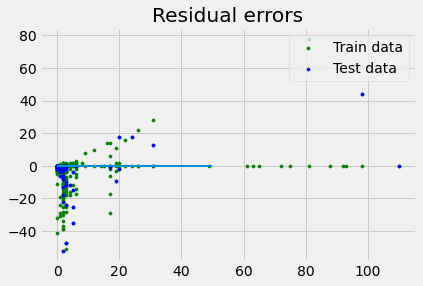

In [ ]:
# setting plot style
plt.style.use('fivethirtyeight')
# plotting residual errors in training data
plt.scatter(modellr.predict(x_train), modellr.predict(x_train) - y_train,
			color = "green", s = 10, label = 'Train data')
# plotting residual errors in test data
plt.scatter(modellr.predict(x_test), modellr.predict(x_test) - y_test,
			color = "blue", s = 10, label = 'Test data')
# plotting line for zero residual error
plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2)
# plotting legend
plt.legend(loc = 'upper right')
# plot title
plt.title("Residual errors")
# method call for showing the plot
plt.show()

5. RANDOM FOREST METHOD 1 

In [ ]:
from  sklearn.ensemble import RandomForestRegressor
np.random.seed(42)
x=merged.drop("Chla",axis=1)
y=merged["Chla"]
a_train, a_test, b_train, b_test =train_test_split(x,y,test_size=0.2)
model2=RandomForestRegressor()
model2.fit(a_train,b_train)

RandomForestRegressor()

In [ ]:
model2.score(a_test,b_test)

0.2725395311298513

In [ ]:
from sklearn.metrics import r2_score
b_test_mean=np.full(len(b_test),b_test.mean())

In [ ]:
b_test_mean

array([10.75339344, 10.75339344, 10.75339344, 10.75339344, 10.75339344,
       10.75339344, 10.75339344, 10.75339344, 10.75339344, 10.75339344,
       10.75339344, 10.75339344, 10.75339344, 10.75339344, 10.75339344,
       10.75339344, 10.75339344, 10.75339344, 10.75339344, 10.75339344,
       10.75339344, 10.75339344, 10.75339344, 10.75339344, 10.75339344,
       10.75339344, 10.75339344, 10.75339344, 10.75339344, 10.75339344,
       10.75339344, 10.75339344, 10.75339344, 10.75339344, 10.75339344,
       10.75339344, 10.75339344, 10.75339344, 10.75339344, 10.75339344,
       10.75339344, 10.75339344, 10.75339344, 10.75339344, 10.75339344,
       10.75339344, 10.75339344, 10.75339344, 10.75339344, 10.75339344,
       10.75339344, 10.75339344, 10.75339344, 10.75339344, 10.75339344,
       10.75339344, 10.75339344, 10.75339344, 10.75339344, 10.75339344,
       10.75339344])

In [ ]:
r2_score(b_test,b_test)

1.0

6. RANDOM FOREST METHOD 2 

In [ ]:
import numpy as np
labels = np.array(merged['Chla'])
features=merged.drop('Chla',axis = 1)
merged1 = list(features.columns)
features=np.array(features)

In [ ]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [ ]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (228, 14)
Training Labels Shape: (228,)
Testing Features Shape: (77, 14)
Testing Labels Shape: (77,)


In [ ]:
# The baseline predictions are the historical averages
baseline_preds = test_features[:, merged1.index('mxPH')]
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  9.56


In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [ ]:
# Use the forest's predict method on the test data
predrf = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predrf - test_labels)

In [ ]:
print('Mean Absolute Error:', mean_absolute_error(test_labels,predrf ))
print('Mean Squared Error:', mean_squared_error(test_labels,predrf))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(test_labels,predrf)))

Mean Absolute Error: 9.040829688311689
Mean Squared Error: 202.53904396394577
Root Mean Squared Error: 14.23162126969186


In [ ]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = merged1, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

In [ ]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_features, train_labels)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = merged1, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(merged, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: mxPH                 Importance: 0.39
Variable: Cl                   Importance: 0.13
Variable: oPO4                 Importance: 0.1
Variable: NO3                  Importance: 0.09
Variable: PO4                  Importance: 0.08
Variable: NH4                  Importance: 0.07
Variable: mnO2                 Importance: 0.06
Variable: high                 Importance: 0.04
Variable: Chla                 Importance: 0.01
Variable: spring               Importance: 0.01
Variable: summer               Importance: 0.01
Variable: winter               Importance: 0.01
Variable: low                  Importance: 0.01
Variable: autumn               Importance: 0.0


**PROPOSED METHODOLOGY**

# *AUTO ARIMA*

In [ ]:
merged.columns

Index(['mxPH', 'mnO2', 'Cl', 'NO3', 'NH4', 'oPO4', 'PO4', 'Chla', 'autumn',
       'spring', 'summer', 'winter', 'high', 'low', 'medium'],
      dtype='object')

In [ ]:
ind_features=['mxPH', 'mnO2', 'Cl', 'NO3', 'NH4', 'oPO4', 'PO4', 'autumn',
       'spring', 'summer', 'winter', 'high', 'low', 'medium']

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
training_data=merged[0:228]
testing_data=merged[228:]

In [ ]:
from pmdarima import auto_arima

In [ ]:
model1=auto_arima(y=training_data['Chla'],exogenous=training_data[ind_features],trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1953.904, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1991.468, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1948.761, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1957.286, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2075.269, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1950.586, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1950.583, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1952.586, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1975.017, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.961 seconds


In [ ]:
model1.fit(training_data['Chla'],training_data[ind_features])

ARIMA(order=(1, 0, 0), scoring_args={}, suppress_warnings=True)

In [ ]:
prediction=model1.predict(n_periods=len(testing_data), X=testing_data[ind_features])

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
testing_data.insert(loc=1,column='prediction',value=prediction)

<Axes: >

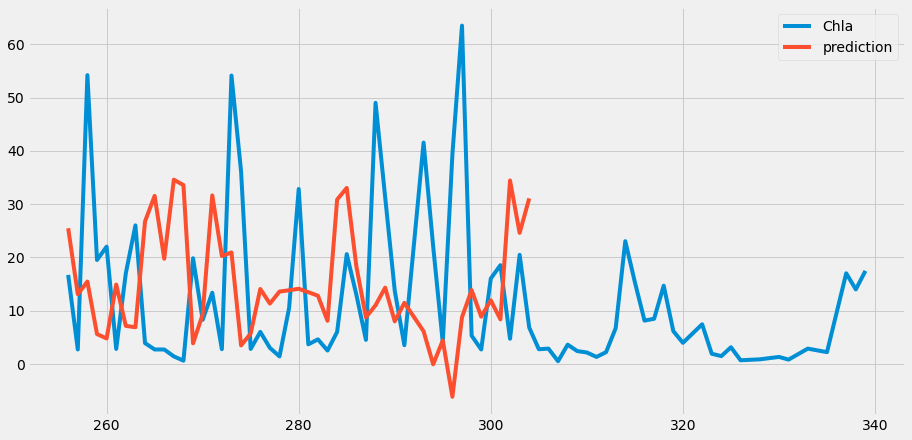

In [ ]:
testing_data[['Chla','prediction']].plot(figsize=(14,7))

In [ ]:
Rmse=np.sqrt(mean_squared_error(testing_data['Chla'],prediction))
Rmse

14.06923741712625

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
mean_absolute_error(testing_data['Chla'],prediction)

11.054877570807383

In [ ]:
mape = 100-(prediction/ training_data['Chla'])
mape

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
300   NaN
301   NaN
302   NaN
303   NaN
304   NaN
Length: 285, dtype: float64

In [ ]:
accuracy= np.mean(mape)
accuracy

93.55062661060715